In [ ]:
!pip install wfdb

     |████████████████████████████████| 122kB 14.0MB/s 


In [ ]:
from wfdb import io, plot
import wfdb
import os
import gc
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
#%matplotlib notebook
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout, Input
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
import time
import keras
from keras.optimizers import RMSprop, Adam
import pywt
from sklearn.model_selection import train_test_split

In [ ]:
import tensorflow as tf
from sklearn.utils import resample
#tf.compat.v1.keras.layers.CuDNNLSTM

In [ ]:
def comments_to_dict(comments):
    key_value_pairs = [comment.split(':') for comment in comments]
    return {pair[0]: pair[1] for pair in key_value_pairs}

In [ ]:
from google.colab import drive
#drive.flush_and_unmount()
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
#load data here
data_path='/gdrive/My Drive/Data set/ECG/ecg_dataset'

In [ ]:
data_folder = 'data'
db = 'ptbdb'
record_names = io.get_record_list(db)

In [ ]:
def record_to_row(record, patient_id):
    row = {}
    row['patient'] = patient_id
    row['name'] = record.record_name
    row['label'] = comments_to_dict(record.comments)['Reason for admission'][1:]
    row['signals'] = record.p_signal
    row['signal_length'] = record.sig_len
    channels = record.sig_name
    signals = record.p_signal.transpose()
    
    row['channels'] = channels
    
    for channel, signal in zip(channels, signals):
        row[channel] = signal
        
    return row

In [ ]:
records = []
for record_name in tqdm(record_names):
    record = io.rdrecord(record_name=os.path.join(data_path, record_name))
    label = comments_to_dict(record.comments)['Reason for admission'][1:]
    patient = record_name.split('/')[0]
    signal_length = record.sig_len
    records.append({'name':record_name, 'label':label, 'patient':patient, 'signal_length':signal_length})
    
channels = record.sig_name
df_records = pd.DataFrame(records)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [ ]:
df_records.shape

(549, 4)

In [ ]:
selected_labels = [
    'Healthy control',
    'Myocardial infarction'
    ]
df_selected = df_records.loc[df_records['label'].isin(selected_labels)]
label_map = {label: value for label, value in zip(selected_labels, range(len(selected_labels)))}

In [ ]:
df_selected.shape

(448, 4)

In [ ]:
test_patients = []
train_patients = []
test_size = 0.2
channels
for label in selected_labels:
    df_selected = df_records.loc[df_records['label'] == label]
    patients = df_selected['patient'].unique()
    n_test = math.ceil(len(patients)*test_size)
    test_patients+=list(np.random.choice(patients, n_test, replace=False))
    train_patients+=list(patients[np.isin(patients, test_patients, invert=True)])

In [ ]:
def make_whole_set(df_data, channels, label_map, record_id,window_size):
    n_windows = df_data.shape[0]
    
    min_length = df_data['signal_length'].min()

    if window_size is None:
      window_size = min_length

    dataX = np.zeros((n_windows, len(channels), window_size))
    dataY = np.zeros((n_windows, len(label_map)))
    
    record_list = []
    
    nth_window = 0
    for i, (patient, record) in enumerate(tqdm(df_data.iterrows())):
        # read the record, get the signal data and transpose it
        signal_data = io.rdrecord(os.path.join(data_path, record['name'])).p_signal[0:window_size].transpose()
       
        dataX[i] = np.array(signal_data)
        dataY[i][label_map[record.label]] = 1
        
        
        if record_id:
            record_list = [record['name']]
        
    return dataX, dataY, record_list,window_size

In [ ]:
def make_set(df_data, channels, label_map, record_id, window_size=1024):
    n_windows = 0
    
    for _, record in tqdm(df_data.iterrows()):
        n_windows+= record['signal_length']//window_size

    dataX = np.zeros((n_windows, len(channels), window_size))
    dataY = np.zeros((n_windows, len(label_map)))
    
    record_list = []
    
    nth_window = 0
    for i, (patient, record) in enumerate(tqdm(df_data.iterrows())):
        # read the record, get the signal data and transpose it
        signal_data = io.rdrecord(os.path.join(data_path, record['name'])).p_signal.transpose()
        n_rows = signal_data.shape[-1]
        n_windows = n_rows//window_size
        dataX[nth_window:nth_window+n_windows] = np.array([signal_data[:,i*window_size:(i+1)*window_size] for i in range(n_windows)])
        dataY[nth_window:nth_window+n_windows][:, label_map[record.label]] = 1
        nth_window+=n_windows
        
        if record_id:
            record_list+= n_windows*[record['name']]
        
    return dataX, dataY, record_list




def denoise(data):
    # wavedec
    coeffs = pywt.wavedec(data=data, wavelet='db8', level=9)
    cA9, cD9, cD8, cD7, cD6, cD5, cD4, cD3, cD2, cD1 = coeffs

    # threshold
    threshold = (np.median(np.abs(cD1)) / 0.6745) * (np.sqrt(2 * np.log(len(cD1))))
    cD1.fill(0)
    cD2.fill(0)
    for i in range(1, len(coeffs) - 2):
        coeffs[i] = pywt.threshold(coeffs[i], threshold)

    rdata = pywt.waverec(coeffs=coeffs, wavelet='db8')
    return rdata

In [ ]:
# df_patient_records = df_records.set_index('patient')
# df_train_patients = df_patient_records.loc[train_patients]
# df_test_patients = df_patient_records.loc[test_patients]
# window_size = 1024#df_records['signal_length'].min()
# #trainX, trainY, _ = make_set(df_train_patients, channels, label_map, False, window_size)
# testX, testY, record_list = make_set(df_test_patients, channels, label_map, True, window_size)

In [ ]:
def make_model(input_shape, output_dim, lstm_layer, dropout=0.2):
    print("model dim: ", input_shape, output_dim)
    model = Sequential()
    model.add(lstm_layer(256, return_sequences=True, input_shape=input_shape, batch_size=None))
    model.add(Dropout(dropout))
    model.add(lstm_layer(128, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(64))
    model.add(Dropout(dropout))
    model.add(Dense(output_dim, activation='softmax'))
    model.compile(loss='binary_crossentropy',metrics=[tf.keras.metrics.BinaryAccuracy()] , optimizer='adam')
    
    return model

In [ ]:
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [ ]:
np.random.seed(1337)
test_patients = []
train_patients = []
test_size = 0.2
channels
for label in selected_labels:
    df_selected = df_records.loc[df_records['label'] == label]
    patients = df_selected['patient'].unique()
    n_test = math.ceil(len(patients)*test_size)
    test_patients+=list(np.random.choice(patients, n_test, replace=False))
    train_patients+=list(patients[np.isin(patients, test_patients, invert=True)])
    
df_patient_records = df_records.set_index('patient')
df_train_patients = df_patient_records.loc[train_patients]
df_test_patients = df_patient_records.loc[test_patients]
#df_records['signal_length'].min()

In [ ]:
df_train_patients.label.value_counts()

Myocardial infarction    301
Healthy control           64
Name: label, dtype: int64

In [ ]:
#up sampling the miniority class of train dataset
df_train_majority = df_train_patients[df_train_patients.label=="Myocardial infarction"]
df_train_minority = df_train_patients[df_train_patients.label=="Healthy control"]
df_train_minority_upsampled = resample(df_train_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=301,    # to match majority class
                                 random_state=123) # reproducible results
df_train_patients = pd.concat([df_train_majority, df_train_minority_upsampled])
df_train_patients.label.value_counts()

Healthy control          301
Myocardial infarction    301
Name: label, dtype: int64

In [ ]:
df_test_patients.label.value_counts()

Myocardial infarction    67
Healthy control          16
Name: label, dtype: int64

In [ ]:
#up sampling the miniority class of test dataset
df_test_majority = df_test_patients[df_test_patients.label=="Myocardial infarction"]
df_test_minority = df_test_patients[df_test_patients.label=="Healthy control"]
df_test_minority_upsampled = resample(df_test_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=67,    # to match majority class
                                 random_state=123) # reproducible results
df_test_patients = pd.concat([df_test_majority, df_test_minority_upsampled])
df_test_patients.label.value_counts()

Myocardial infarction    67
Healthy control          67
Name: label, dtype: int64

In [ ]:
# trainX, trainY, _,window_size = make_whole_set(df_train_patients, channels, label_map, False, None)

# testX, testY, record_list,_ = make_whole_set(df_test_patients, channels, label_map, True, window_size)
window_size = 1024
trainX, trainY, _ = make_set(df_train_patients, channels, label_map, False, window_size)
testX, testY, record_list = make_set(df_test_patients, channels, label_map, True,window_size)

#split validation set
trainX, valX, trainY, valY = train_test_split(trainX, trainY, test_size=0.25, random_state=1)

#Shuffle order of train set
trainX, trainY = shuffle(trainX, trainY)

#Since we have a large class inbalance we need to udjust the weights for it.
fractions = 1-trainY.sum(axis=0)/len(trainY)
weights = fractions[trainY.argmax(axis=1)]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


In [ ]:
# trainX, valX, trainY, valY = train_test_split(trainX, trainY, test_size=0.25, random_state=1)
# #Since we have a large class inbalance we need to udjust the weights for it.
# fractions = 1-trainY.sum(axis=0)/len(trainY)
# weights = fractions[trainY.argmax(axis=1)]
valX.shape

(16813, 15, 1024)

In [ ]:
testX.shape

(15095, 15, 1024)

In [ ]:
trainX.shape

(50438, 15, 1024)

In [ ]:
trainY.shape

(50438, 2)

In [ ]:
len(weights)

50438

In [ ]:
for i in range(len(trainX)):
  for j in range(0,14):
    trainX[i][j] = denoise(trainX[i][j])

/usr/local/lib/python3.6/dist-packages/pywt/_multilevel.py:45: UserWarning: Level value of 9 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))


In [ ]:
for i in range(len(testX)):
  for j in range(0,14):
    trainX[i][j] = denoise(trainX[i][j])

/usr/local/lib/python3.6/dist-packages/pywt/_multilevel.py:45: UserWarning: Level value of 9 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))


In [ ]:
for i in range(len(valX)):
  for j in range(0,14):
    valX[i][j] = denoise(valX[i][j])

/usr/local/lib/python3.6/dist-packages/pywt/_multilevel.py:45: UserWarning: Level value of 9 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))


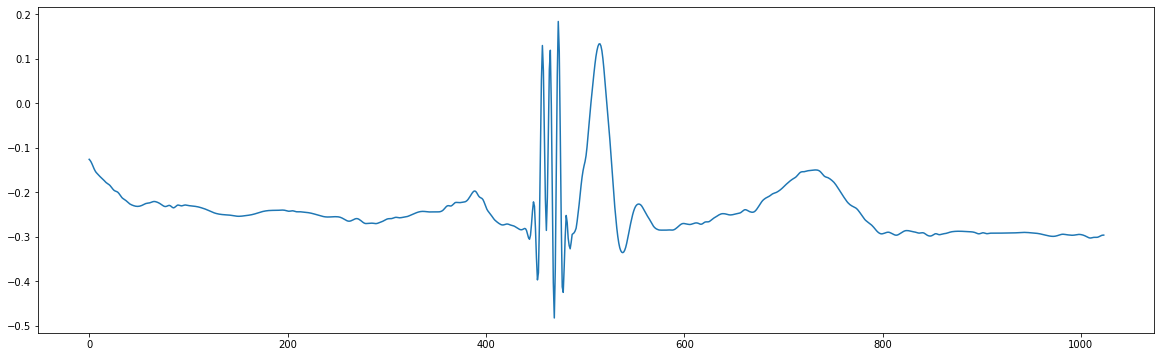

In [ ]:
 import matplotlib.pyplot as plt2
plt2.figure(figsize=(20,6)) 
plt2.plot(valX[7][0])
plt2.show()
#plt2.savefig("/gdrive/My Drive/model_output/first_4096.png")

In [ ]:
#  weights = 50438
%load_ext tensorboard
model_Path = '/gdrive/My Drive/model_output'

filepath = os.path.join(model_Path, "weights-improvement-{epoch:02d}-bigger.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

model_name = 'two_classes'
model_folder = os.path.join(model_Path,'tensorlogs/'+ model_name + "-logs/")

if not os.path.isdir(model_folder):
    n_logs = 0
else:
    n_logs = len(os.listdir(model_folder))
    
tensorboard_logs = os.path.join(model_folder, "%inth_run"%n_logs)
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=tensorboard_logs, write_graph=False)
time_callback = TimeHistory()
callbacks = [checkpoint, tensorboard_callback, time_callback]

model = make_model((trainX.shape[1], trainX.shape[2]), trainY.shape[-1], LSTM)

model.fit(trainX, trainY, validation_data = (valX,valY), epochs=100, batch_size=256,sample_weight=weights, callbacks=callbacks)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
model dim:  (15, 1024) 2
Epoch 1/100
198/198 [==============================] - 8s 26ms/step - loss: 0.2738 - binary_accuracy: 0.6975 - val_loss: 0.3155 - val_binary_accuracy: 0.8641

Epoch 00001: loss improved from inf to 0.22032, saving model to /gdrive/My Drive/model_output/weights-improvement-01-bigger.hdf5
Epoch 2/100
198/198 [==============================] - 4s 18ms/step - loss: 0.1232 - binary_accuracy: 0.8981 - val_loss: 0.2206 - val_binary_accuracy: 0.9092

Epoch 00002: loss improved from 0.22032 to 0.11066, saving model to /gdrive/My Drive/model_output/weights-improvement-02-bigger.hdf5
Epoch 3/100
198/198 [==============================] - 4s 18ms/step - loss: 0.0776 - binary_accuracy: 0.9377 - val_loss: 0.1747 - val_binary_accuracy: 0.9324

Epoch 00003: loss improved from 0.11066 to 0.07086, saving model to /gdrive/My Drive/model_output/weights-improvement-03-bigger.hdf5
Epoch 4/100
1

In [ ]:
tensorboard_logs

'/gdrive/My Drive/model_output/tensorlogs/two_classes-logs/3nth_run'

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 15, 256)           1311744   
_________________________________________________________________
dropout (Dropout)            (None, 15, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 15, 128)           197120    
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 2)                 1

In [ ]:
!tensorboard dev upload \
  --logdir /gdrive/My\ Drive/model_output/tensorlogs/two_classes-logs/3nth_run \
  --name " 1024 with denoise" \
  --description "n_batch = 256,n_epochs = 100,validation" \
  --one_shot

2021-02-11 06:39:06.676112: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/coJpqmJ9QeOpwGx2U13N3g/

[2021-02-11T06:39:08] Started scanning logdir.
[2021-02-11T06:39:09] Total uploaded: 400 scalars, 0 tensors, 0 binary objects
[2021-02-11T06:39:09] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/coJpqmJ9QeOpwGx2U13N3g/


In [ ]:
testX.shape

(15095, 15, 1024)

In [ ]:
output = model.predict_classes(testX)
output

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([1, 1, 1, ..., 0, 0, 0])

In [ ]:
confusion_matrix(testY.argmax(axis=1), output)

array([[5432, 2151],
       [ 635, 6877]])

In [ ]:
y_pred = output
y_pred

array([1, 1, 1, ..., 0, 0, 0])

In [ ]:
y_true = testY.argmax(axis=1)
y_true

array([1, 1, 1, ..., 0, 0, 0])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.90      0.72      0.80      7583
           1       0.76      0.92      0.83      7512

    accuracy                           0.82     15095
   macro avg       0.83      0.82      0.81     15095
weighted avg       0.83      0.82      0.81     15095



In [ ]:
testY

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [ ]:
(output == testY.argmax(axis=1)).sum()/len(output)

0.8154355746936072

In [ ]:
summed = pd.DataFrame({'record':record_list, 'predictions':output, 'label':testY.argmax(axis=1)}).groupby('record').mean()
control = summed.loc[summed['label'] == 0]
#print(control)
print("Healthy control accuracy: "+  str((control['predictions'] <= 0.5).sum()/control.shape[0]))

infarct = summed.loc[summed['label'] == 1]
#print(infarct)
print("Myocardial infarction accuracy: "+  str((infarct['predictions'] > 0.5).sum()/infarct.shape[0]))

Healthy control accuracy: 0.8125
Myocardial infarction accuracy: 0.9552238805970149
